In [11]:
# Importing and organizing necessary dataset
import pandas as pd
import os
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import networkx as nx
with open('groceries.txt', 'r') as file:
    data = file.read() # Import the data file 
transactions = [line.strip().split(',')
for line in data.split('\n') if line] # Split the data into a list of transactions
print("Sample Transactions:") # Examining the first 5 rows to check for accuracy
for transaction in transactions[:5]:
    print(transaction)

Sample Transactions:
['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups']
['tropical fruit', 'yogurt', 'coffee']
['whole milk']
['pip fruit', 'yogurt', 'cream cheese ', 'meat spreads']
['other vegetables', 'whole milk', 'condensed milk', 'long life bakery product']


In [4]:
# One-hot encoding. Since I had minimum experience in this with Python, this part is assisted by ChatGPT and Data Camp
!pip install mlxtend
from mlxtend.preprocessing import TransactionEncoder # This package is needed for deriving association rules
te = TransactionEncoder() # Encode transaction data into binary format
te_array = te.fit(transactions).transform(transactions) # Transforming transaction date into binary matrix to make it easier to interpret
df_encoded = pd.DataFrame(te_array, columns = te.columns_) # Transforming the array into pandas data frame to make it more organized
print(df_encoded.head()) # Display the data frame

   Instant food products  UHT-milk  abrasive cleaner  artif. sweetener  \
0                  False     False             False             False   
1                  False     False             False             False   
2                  False     False             False             False   
3                  False     False             False             False   
4                  False     False             False             False   

   baby cosmetics  baby food   bags  baking powder  bathroom cleaner   beef  \
0           False      False  False          False             False  False   
1           False      False  False          False             False  False   
2           False      False  False          False             False  False   
3           False      False  False          False             False  False   
4           False      False  False          False             False  False   

   ...  turkey  vinegar  waffles  whipped/sour cream  whisky  white bread  \
0  

In [5]:
#Define thresholds
support_threshold = 0.01 # This means that I am interested in items that appeared in at least 1% of transactions to avoid insignificant items
apriori_products = apriori(df_encoded, min_support = support_threshold, use_colnames=True) # (Assisted by ChatGPT) Apriori function will find the most frequent itemsets that meets the minimum support threshold
apriori_products = apriori_products.sort_values(by='support', ascending=False) # Sorting items by support values
print(apriori_products.head()) #Displaying the top 5 most common itemsets

     support            itemsets
85  0.255516        (whole milk)
55  0.193493  (other vegetables)
65  0.183935        (rolls/buns)
74  0.174377              (soda)
86  0.139502            (yogurt)


In [6]:
#Generate Association Rules
confidence_threshold = 0.2 # Set up a confidence threshold. This means that I am interested in looking at events where consequent occurs at least 20% of time when antecedent occurs
lift_threshold = 3.0 # Set up lift threshold. A lift threshold of 3 means that I am only interested in rules where items are at least 3 times more likely to be purchased together
rules = association_rules(apriori_products, metric='confidence', min_threshold = confidence_threshold) # Generate association rules from itemsets using the confidence interval
rules = rules[rules['lift'] > lift_threshold] # Filter products that only have lift threshold higher than 3
rules = rules.sort_values(by='confidence', ascending = False) # Sorted by confidence threshold 
print(rules.head(3))

#Interpreting the first rule (index 217), it means that 1.03% of the transactions include both citrus fruit, root vegetables, 
#and other vegetables. When customers buy citrus fruit and root vegetables, there is a 58.62% chance that they will also buy
#other vegetables. The chance of other vegetables occuring is 3 times more likely to occur when there are citrus fruit and root
#vegetables vs other products.

                           antecedents         consequents  \
217    (root vegetables, citrus fruit)  (other vegetables)   
168  (tropical fruit, root vegetables)  (other vegetables)   
215   (other vegetables, citrus fruit)   (root vegetables)   

     antecedent support  consequent support   support  confidence      lift  \
217            0.017692            0.193493  0.010371    0.586207  3.029608   
168            0.021047            0.193493  0.012303    0.584541  3.020999   
215            0.028876            0.108998  0.010371    0.359155  3.295045   

     leverage  conviction  zhangs_metric  
217  0.006948    1.949059       0.681990  
168  0.008231    1.941244       0.683367  
215  0.007224    1.390354       0.717225  


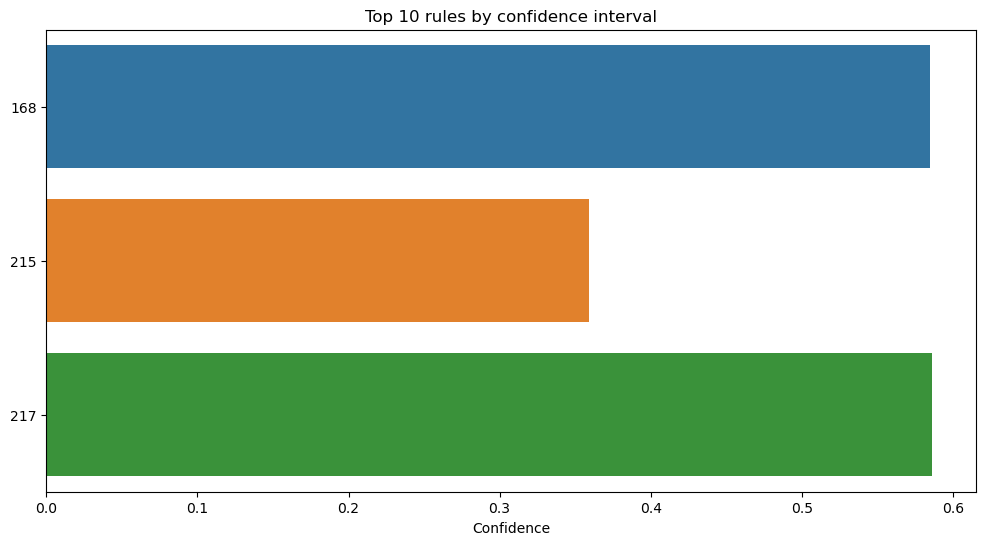

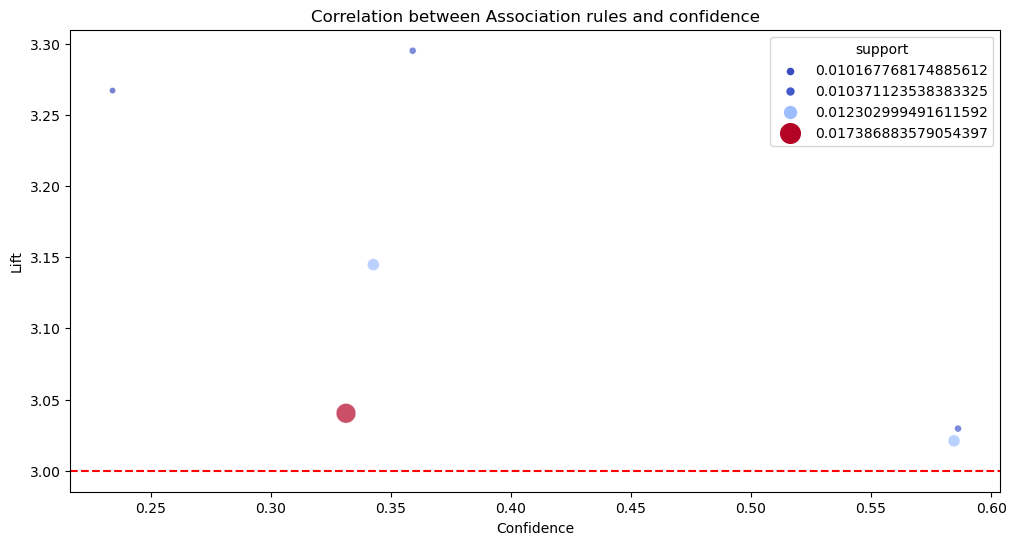

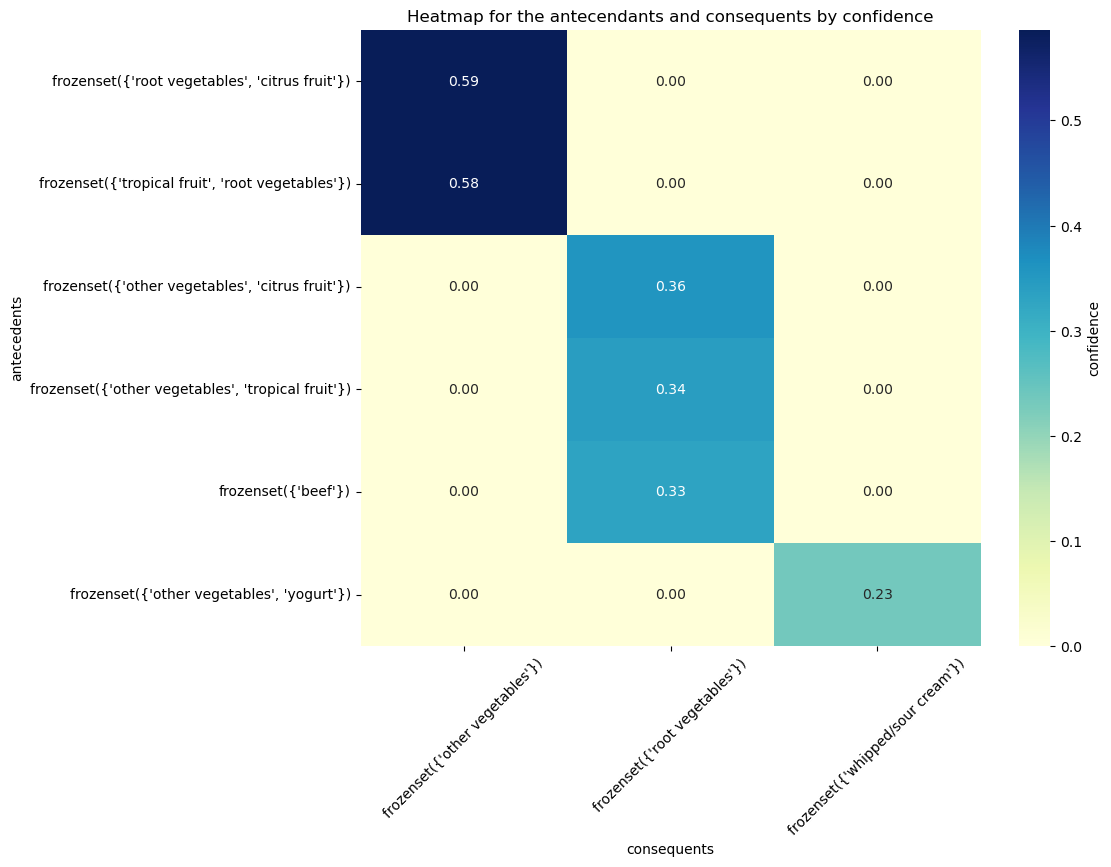

In [13]:
#Creating visualizations

#Creating a seaborn barplot
import seaborn as sns # I researched about this and found that it might be useful to analyze random distribution. Will be using this in the problem
top_rules = rules.head(3)
plt.figure(figsize = (12,6))
sns.barplot(x=top_rules['confidence'], y=top_rules.index, orient = 'h') #Plotting the seaborn barplot chart, assisted by ChatGPT
plt.xlabel('Confidence')
plt.title('Top 10 rules by confidence interval')
plt.show()
#This plot shows the top 3 rules by confidence interval.

#Creating a seaborn scatterplot
rules_sorted = rules.sort_values(by='support', ascending=False)
plt.figure(figsize = (12,6))
sns.scatterplot(x='confidence', y='lift', size='support', hue='support', sizes=(20,200), data=rules_sorted, palette='coolwarm', alpha = 0.7) #Plotting the seaborn scatter plot
plt.title('Correlation between Association rules and confidence')
plt.axhline(y=3, color='red', linestyle='--', label='Lift threshold = 3')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.show()

#Creating a seaborn heatmap(Assisted by ChatGPT)
heatmap_data = rules.pivot_table(index='antecedents', columns='consequents', values='confidence', fill_value=0) #Organizing the data

sorted_index = heatmap_data.sum(axis=1).sort_values(ascending=False).index #Sorting the heatmap by confidence 
heatmap_data = heatmap_data.loc[sorted_index]

plt.figure(figsize=(10,8))#Creating the figure size
sns.heatmap(heatmap_data, cmap = 'YlGnBu', annot = True, fmt = '.2f', cbar_kws = {'label': 'confidence'})#Plotting the heatmap
plt.title('Heatmap for the antecendants and consequents by confidence')#Creating a title
plt.xlabel('consequents')#Creating x label
plt.ylabel('antecedents')#Creating y label
plt.xticks(rotation=45)#Rotate the x label 45 degrees to make it easier to read
plt.yticks(rotation=0)#Keep y label the same to make it easier to read
plt.show()
#Interpreting this heatmap using the first antecedent and consequent. The confidence level is 0.59, which means that when 
#frozenset(root vegetables, citrus fruit) is bought, there is a 59% chance that other vegetables will be bought too, indicating
#a strong correlation between the two. 

#The high confidence values for the two most important antecedents (root vegetables, citrus fruit) and (tropical fruit, root vegetables)
#indicates a strong correlation of the purchasing of the subsequent consequent items.